In [1]:
import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F
import os 

In [2]:
# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Data")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "Grote_data.xlsx")
df = pd.read_excel(file_path)

In [3]:
# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# ✅ 2. Define Dutch Stopwords & Cleaning Function
dutch_stopwords = {"de", "het", "een", "en", "van", "ik", "te", "dat", "die", "in", "je", "is",
                   "niet", "op", "aan", "met", "als", "voor", "zijn", "was", "heeft", "heb",
                   "om", "bij", "of", "geen", "dan", "toch", "maar", "wel", "meer", "doen",
                   "ook", "kan", "mijn", "zo", "dus", "zou", "kunnen"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Remove enumerations
    text = re.sub(r'\b\d+\.\b', '', text)  # Remove numbered lists
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in dutch_stopwords])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ 3. Merge Context + Question & Apply Cleaning
df["clean_text"] = (df["context"] + " " + df["question"]).apply(clean_text)

# ✅ 4. Encode Theme Labels as Numbers
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}  # ✅ Ensure mapping back from ID to theme
df["theme_id"] = df["theme"].map(theme_to_id)

C:\Users\jefva\AppData\Local\Temp\ipykernel_50544\1726228797.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)


In [4]:
# ✅ 5. Fix Class Imbalance with Oversampling
theme_counts = df["theme_id"].value_counts()
median_count = theme_counts.median()  # Set balancing threshold

# Oversample rare themes
sampling_strategy = {theme: int(median_count) for theme in theme_counts.index if theme_counts[theme] < median_count}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, y_resampled = ros.fit_resample(df[["clean_text"]], df["theme_id"])
df_resampled = pd.DataFrame({"clean_text": X_resampled["clean_text"], "theme_id": y_resampled})


C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [5]:
# ✅ 6. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_resampled["clean_text"].tolist(), df_resampled["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df_resampled["theme_id"]
)

# ✅ 7. Load BERT Tokenizer & Define Dataset Class
model_name = "bert-base-multilingual-cased"  # mBERT
tokenizer = BertTokenizer.from_pretrained(model_name)

class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts, train_labels, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jefva\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
# ✅ 8. Load BERT Model for Classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# ✅ 9. Define Training Arguments (With Early Stopping)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # Increased epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True
)

# ✅ 10. Define Metrics for Evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=1)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ 11. Train Model with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

trainer.train()

C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.999100,1.118657,0.712294,0.746165,0.712294,0.717246
2,0.611800,0.743108,0.803775,0.833505,0.803775,0.813255
3,0.790000,0.667627,0.833702,0.865257,0.833702,0.843049
4,0.198800,0.623152,0.855977,0.878122,0.855977,0.859783
5,0.230700,0.616644,0.865329,0.883801,0.865329,0.869235
6,0.353700,0.584618,0.871791,0.896243,0.871791,0.877754
7,0.325200,0.579641,0.876722,0.899700,0.876722,0.882259
8,0.272600,0.570085,0.878932,0.903283,0.878932,0.884888


TrainOutput(global_step=23528, training_loss=0.575632958807525, metrics={'train_runtime': 5868.7533, 'train_samples_per_second': 32.067, 'train_steps_per_second': 4.009, 'total_flos': 4.953095598686208e+16, 'train_loss': 0.575632958807525, 'epoch': 8.0})

In [8]:
# ✅ 13. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
predictions = trainer.predict(test_dataset)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (1st Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 5:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label


Dynamic Threshold: 0.12235041707754135


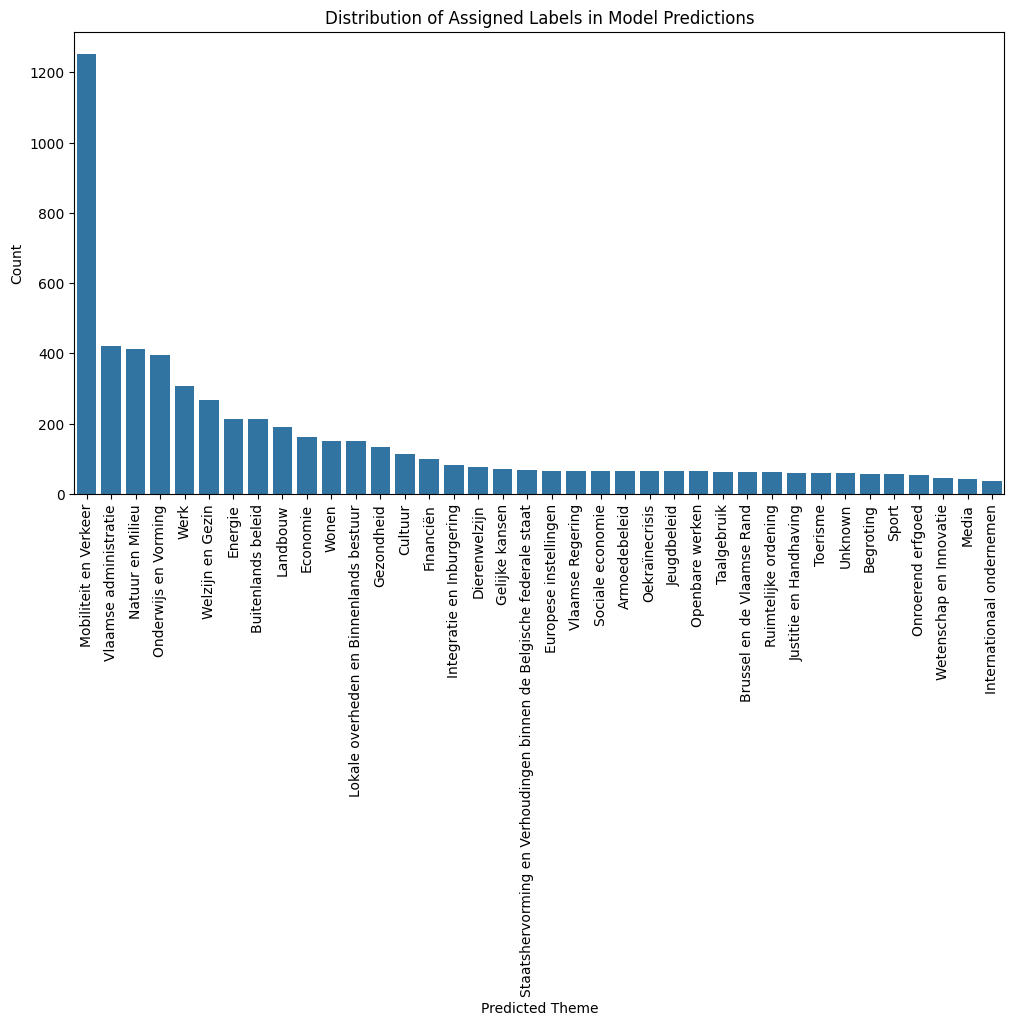

In [9]:
# ✅ 15. Visualize Distribution of Predicted Themes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Replace this with your actual predictions DataFrame
# Example: If your predictions are stored in a variable `predicted_labels`
# Convert it into a DataFrame for visualization
df = pd.DataFrame({"Predicted_Theme": predicted_labels})

# ✅ Count occurrences of each predicted theme
label_counts = df["Predicted_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Predicted Theme")
plt.ylabel("Count")
plt.title("Distribution of Assigned Labels in Model Predictions")
plt.show()
